In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

In [3]:
from keras import models
from keras.models import load_model
loaded_model=load_model('Models/inception_model.h5')

In [4]:
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [5]:
predicted = np.argmax ( loaded_model.predict ( X_test ), axis=-1 )

113/113 [==============================] - 4s 32ms/step


In [6]:
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

In [7]:
emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
predictions = pd.DataFrame(predicted, columns = ['predicted_classes'])
predictions['predicted_classes']=predictions['predicted_classes'].map(emotions_names)
actual=pd.DataFrame(y_classes, columns = ['actual_classes'])
actual['actual_classes']=actual['actual_classes'].map(emotions_names)

In [8]:
predictions['predicted_classes'][0]

'Fear'

In [9]:
actual['actual_classes'][0]

'Angry'

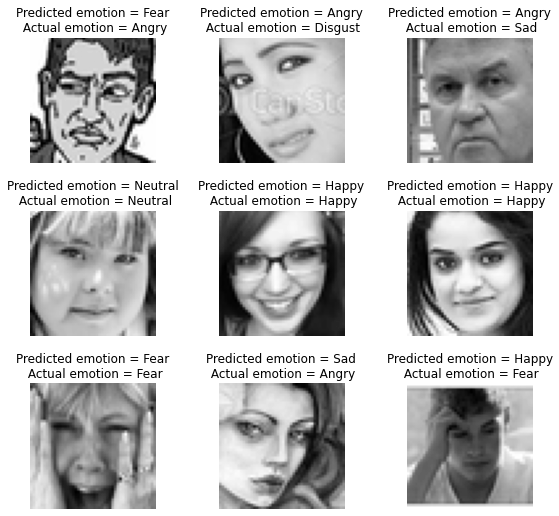

In [10]:
L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (9,9))
axes = axes.ravel()
for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(48,48),cmap='gray')
    axes[i].set_title(f"Predicted emotion = {(predictions['predicted_classes'][i])}\n Actual emotion = {(actual['actual_classes'][i])}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

# Making a prediction on an image

First of all, we need to detect the faces inside an image. This will allow us to :

focus on the region of the face
stop the prediction if no face is recognized.
To do so, we use OpenCV faceCascade classifier. Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

The term "Cascade" comes from the fact that when a window is explored and no face edge is identified, the region is left apart and we move on to the next one using Adaboost classifier. This makes the overall process very efficient.

In [11]:
shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [12]:
nRows, nCols, nDims

(48, 48, 1)

In [13]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = 'Haarcascade/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [14]:
#Extraire les features faciales
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        #Region dans laquelle la face est détectée
        x, y, w, h = det
        #X et y correspondent à la conversion en gris par gray, et w, h correspondent à la hauteur/largeur
    
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray transforme l'image
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        #Zoom sur la face extraite
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

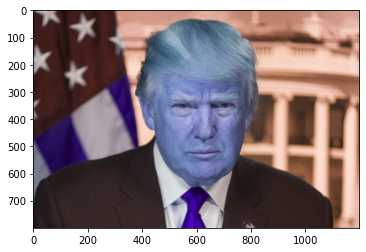

In [15]:
trump = 'test_image.jpg'
trump_face = cv2.imread(trump, cv2.COLOR_BGR2RGB)
plt.imshow(trump_face)

C:\Users\DELL\AppData\Local\Temp\ipykernel_1504\563871144.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
C:\Users\DELL\AppData\Local\Temp\ipykernel_1504\563871144.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current us

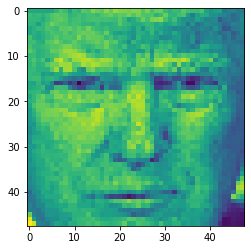

In [16]:
face = extract_face_features(detect_face(trump_face))[0]
plt.imshow(face)

In [17]:
to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = loaded_model.predict(to_predict)
result_num = np.argmax(res)
if result_num==0:
    ans='Angry'
elif result_num==1:
    ans='Disgust'
elif result_num==2:
    ans='Fear'
elif result_num==3:
    ans='Happy'
elif result_num==4:
    ans='Sad'
elif result_num==5:
    ans='Surprise'
else:
    ans='Neutral'

1/1 [==============================] - 0s 34ms/step


Text(0.5, 1.0, 'Angry')

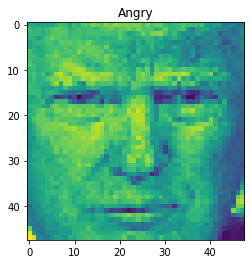

In [18]:
plt.imshow(face)
plt.title(ans)

# Confusion Matrix

Text(69.0, 0.5, 'True label')

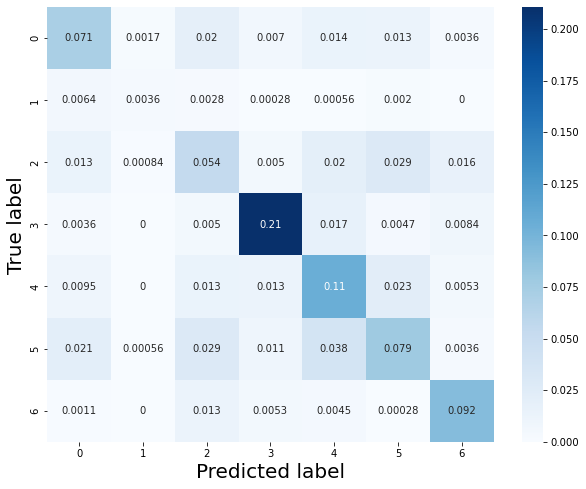

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
cm = metrics.confusion_matrix(actual['actual_classes'], predictions['predicted_classes'])
plt.figure(figsize=(10,8))
sns.heatmap(cm/np.sum(cm),annot=True,cmap='Blues')
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('True label',fontsize=20)

# Final Prediction

## Enhanced Visualization

- add features from manually selected filters (e.g Gabor filters)
- take into account the frequency of eye blinks
- take into account the symetry of the keypoints on a face
- display all the keypoints of the face
- align the face by scaling of the facial features
- add emojis translating the emotion

## a- frequency of eye blink

In [20]:
def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

In [21]:
thresh = 0.25
frame_check = 20
face_detect = dlib.get_frontal_face_detector()
predictor_landmarks = dlib.shape_predictor("landmarks/shape_predictor_68_face_landmarks.dat")

In [22]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

## b- Detect Keypoints to plot them

In [23]:
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

(eblStart, eblEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(ebrStart, ebrEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]

## c- face alignment

In [24]:
def align(gray, rect):
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
 
    # extract the left and right eye (x, y)-coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
        
    # compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
 
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
        
    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
 
    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= self.desiredFaceWidth
    scale = desiredDist / dist
    
    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
    # update the translation component of the matrix
    tX = self.desiredFaceWidth * 0.5
    tY = self.desiredFaceHeight * self.desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
        
    # apply the affine transformation
    (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
    #output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC)
    # return the aligned face
    return output

In [1]:
video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    face_index = 0
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = face_detect(gray,1)
    gray, detected_faces, coord = detect_face(frame)
    try : 
        for (i, rect) in enumerate(rects):

            shape = predictor_landmarks(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # Identify face coordinates
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            face = gray[y:y+h,x:x+w]

            #Zoom on extracted face
            face = zoom(face, (shape_x / face.shape[0],shape_y / face.shape[1]))

            #Cast type float
            face = face.astype(np.float32)

            #Scale
            face /= float(face.max())
            face = np.reshape(face.flatten(), (1, 48, 48, 1))

            #Make Prediction
            prediction = loaded_model.predict(face)
            prediction_result = np.argmax(prediction)
            
            # Rectangle around the face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            for (j, k) in shape:
                cv2.circle(frame, (j, k), 1, (0, 0, 255), -1)

            # 12. Add prediction probabilities
            cv2.putText(frame, "----------------",(40,100 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Emotional report : Face #" + str(i+1),(40,120 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,160 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,180 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,200 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,220 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,240 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,260 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            
            # draw extracted face in the top right corner
            #frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(face * 255, cv2.COLOR_GRAY2RGB)

            # 13. Annotate main image with a label
            if prediction_result == 0 :
                cv2.putText(frame, "Angry",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 1 :
                cv2.putText(frame, "Disgust",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 2 :
                cv2.putText(frame, "Fear",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 3 :
                cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 4 :
                cv2.putText(frame, "Sad",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 5 :
                cv2.putText(frame, "Surprise",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else :
                cv2.putText(frame, "Neutral",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # 5. Eye Detection and Blink Count
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]

            # Compute Eye Aspect Ratio
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            ear = (leftEAR + rightEAR) / 2.0

            # And plot its contours
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
            
             # Compute total blinks and frequency
            #if ear < thresh:
                #flag += 1
                #cv2.putText(frame, "Blink", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)

            #cv2.putText(frame, "Total blinks : " + str(flag), (40, 280 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            #cv2.putText(frame, "Blink Frequency : " + str(int(flag/j)), (40, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)

            # 6. Detect Nose
            nose = shape[nStart:nEnd]
            noseHull = cv2.convexHull(nose)
            cv2.drawContours(frame, [noseHull], -1, (0, 255, 0), 1)

            # 7. Detect Mouth
            mouth = shape[mStart:mEnd]
            mouthHull = cv2.convexHull(mouth)
            cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)

            # 8. Detect Jaw
            jaw = shape[jStart:jEnd]
            jawHull = cv2.convexHull(jaw)
            cv2.drawContours(frame, [jawHull], -1, (0, 255, 0), 1)

            # 9. Detect Eyebrows
            ebr = shape[ebrStart:ebrEnd]
            ebrHull = cv2.convexHull(ebr)
            cv2.drawContours(frame, [ebrHull], -1, (0, 255, 0), 1)
            ebl = shape[eblStart:eblEnd]
            eblHull = cv2.convexHull(ebl)
            cv2.drawContours(frame, [eblHull], -1, (0, 255, 0), 1)
            
            cv2.putText(frame,'Number of Faces : ' + str(len(rects)),(40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
        cv2.imshow('Video', frame)
    except :
        pass
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [27]:
video_capture.release()

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
import cv2
#path='Haarcascade/haarcascade_frontalface_default.xml'
#font_scale=1.5
#font=cv2.FONT_HERSHEY_PLAIN

#rectangle_bgr=(255, 255, 255)
#img=np.zeros((500, 500))
#text="Some text in box"
#(text_width, text_height)=cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
#text_offset_x=10
#text_offset_y=img.shape[0]-25
#box_coords=((text_offset_x, text_offset_y), (text_offset_x+text_width+2, text_offset_y-text_height-2))
#cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
#cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0,0,0), thickness=1)

cap=cv2.VideoCapture(1)
if not cap.isOpened():
    cap=cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open Webcam")
    
while True:
    ret,frame=cap.read()
    faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades + 'Haarcascade/haarcascade_frontalface_default.xml')
    gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces=faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray=gray[y:y+h, x:x+w]
        roi_color=frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 2)
        facess=faceCascade.detectMultiScale(roi_gray)
        if len(facess)==0:
            print("Face not detected")
        else:
            for(ex,ey,ew,eh) in facess:
                face_roi=roi_color[ey:ey+eh, ex:ex+ew]
                
    graytemp=cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    final_image=cv2.resize(graytemp, (48,48))
    final_image=np.expand_dims(final_image, axis=0)
    final_image=np.expand_dims(final_image, axis=0)
    final_image=final_image/255.0
    dataa=torch.from_numpy(final_image)
    dataa=dataa.type(torch.floatTensor)
    dataa=dataa.to(device)
    outputs=loaded_model(dataa)
    pred=F.softmax(outputs, dim=1)
    Predictions=torch.argmax(pred)
    print(Predictions)
    
    font=cv2.FONT_HERSHEY_SIMPLEX
    
    font_scale=1.5
    font=cv2.FONT_HERSHEY_PLAIN
     

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [28]:
video_capture.release()

In [29]:
cap.release()